<a href="https://colab.research.google.com/github/Olesya-Mo/Ideal_learner_model/blob/main/Sequence_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the necessary packages

import random
import pymc
import math
import numpy as np
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
#store the sequences in the dict or anywhere
#random.seed does not work for some reason
#how to make it go into the formulas
#likelihood for each loc at each trial 

In [ ]:
#define the main variables: number of sequences, subjects, trials, locations, probabilities of locations appearing,
#levels of complexity. 

nseq = 10 #number of sequences
ntrial = 10 #number of trials in each sequence
nsubj = 40 #number of subjects
locations = [1,2,3,4] #locations/boxes

seq = np.empty([nseq, ntrial], dtype=int) #creating an empty array to fill it with sequences
weights = np.empty([nseq,len(locations)]) #creating weights for different sequences

#the percentage of times the target would appear in the "main" box
seq_complexity = OrderedDict({'easy': [1, 0, 0, 0]
                     , 'moderate_1':  [0.8, 0.2/3, 0.2/3, 0.2/3]
                     , 'moderate_2':  [0.6, 0.4/3, 0.4/3, 0.4/3]
                     , 'difficult':   [0.25, 0.25, 0.25, 0.25]})

#seq_order = random.choices(list(seq_complexity.keys()), k=nseq, weights=[0.2,0.3,0.3,0.2]) #randomizing the order of the sequences to account for fatigue and exclude influence of toys
#seq_order = random.choices(sequences, k=nseq, weights=[0.2,0.3,0.3,0.2])
#sequences = ['easy','easy','moderate_1','moderate_1','moderate_1','moderate_2','moderate_2','moderate_2','difficult','difficult']


In [ ]:
#create a function that creates sequences. The order of sequences, the locations are pseudorandomized.
#sequences_list variable makes it so that there are enough sequences of each level of complexity -
#as we are mostly interested in moderate level, there are more of those, and less of easy and difficult sequences 

def create_sequences():
    random.seed(12)
    sequences_list = ['easy', 'easy', 'moderate_1', 'moderate_1', 'moderate_1', 
                      'moderate_2', 'moderate_2', 'moderate_2', 'difficult', 'difficult']
    random.shuffle(sequences_list)
    for i in range(nseq):
        #sequences = {}
        sequences = []
        seq_complexity_i = seq_complexity.get(sequences_list[i])
        loc_prob = seq_complexity_i / np.sum(seq_complexity_i)
        np.random.shuffle(locations)
        seq[i] = random.choices(locations, k=ntrial,weights=loc_prob)
        #sequences.__setitem__('seq[i]','sequences_list[i]') 
        sequences.append({'seq': seq,'complexity_level': sequences_list[i]})
    return seq, sequences

#The create_sequences function is defined to generate the sequences of target locations for each trial of each sequence. 
#The function first shuffles a list of sequence complexity levels, then for each sequence, 
#it selects a complexity level from the shuffled list, calculates the probability of the target 
#appearing in each location based on the selected complexity level, shuffles the location list, 
#and uses the random.choices function to randomly select a location for each trial of the sequence 
#based on the calculated location probabilities. 
#The generated sequences are stored in the seq array.


In [ ]:
#with random.sample - if we need not true probabilities but just the amount of times the target appears? 
#the plots will look more "diverse" because of that - otherwise, random.choices adheres to the probabilities,
#so it really takes 80% _probability_, not 80% of _the times_ the target appears

def create_sequences():
    random.seed(12)
    sequences_list = ['easy', 'easy', 'moderate_1', 'moderate_1', 'moderate_1', 'moderate_2', 'moderate_2', 'moderate_2', 'difficult', 'difficult']
    random.shuffle(sequences_list)
    for i in range(nseq):
        seq_complexity_i = seq_complexity.get(sequences_list[i])
        loc_prob = seq_complexity_i / np.sum(seq_complexity_i)
        np.random.shuffle(locations)
        seq[i] = random.sample(locations*int(ntrial*np.sum(seq_complexity_i)),ntrial)
    return seq



In [ ]:
#can not make it store the level of complexity and a corresponding array!
#so now it is not clear what level of complexity is where because it is all shuffled!


create_sequences()


'moderate_2'

In [ ]:

seq[1]

array([3, 1, 3, 4, 3, 4, 1, 4, 4, 3])

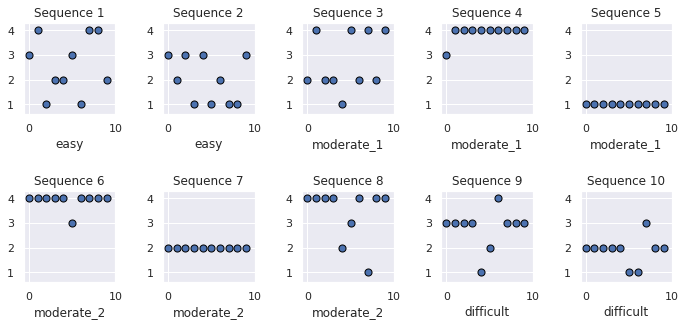

In [ ]:
#create a figure with 10 subplots to look at the sequences
sns.set()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

#flatten the axes array so that we can iterate over it easily
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.scatter(range(len(seq[i])), seq[i], s=50, c='b', marker='o', edgecolors='black')
    ax.set_title("Sequence {}".format(i+1))
    ax.set_xlabel(sequences[i]) #NOT CORRRECT
    ax.set_ylim(0.6,4.3)
    ax.set_xlim(-0.6, 10)

plt.tight_layout(pad=2)
plt.show()


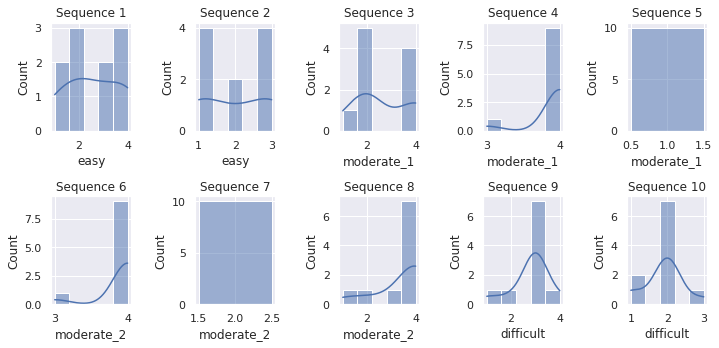

In [ ]:
# Create a figure with 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Flatten the axes array so that we can iterate over it easily
axes = axes.ravel()

# Iterate over the data arrays and plot their distributions in the corresponding subplot
for i, ax in enumerate(axes):
    sns.histplot(seq[i], kde=True, ax=ax)
    ax.set_title("Sequence {}".format(i+1))
    ax.set_xlabel(sequences[i])


# Make the plots look nice
plt.tight_layout()
plt.show()


In [ ]:
#create the necessary formulas for IG (KLD), surprise (negative logarithm), 
#predictive accuracy (not applicable for now: needs an additional model),
#additionaly, likelihood (p) of each event calculated

def kl_divergence(p, q):
    return sum(p[i] * np.log(p[i]/q[i]) for i in range(len(p)))

def neg_log(p):
    return -(math.log2(p))

def bayesian_likelihood(arr, number):
    likelihood = []
    n = len(arr)
    for i in range(n):
        if arr[i] == number:
            count = np.count_nonzero(arr[:i+1] == number)
            likelihood.append((count + 1) / (i + 2 + len(set(arr))))
    return likelihood


In [ ]:
#just looking how it works
print(seq[0])
print('1:', bayesian_likelihood(seq[0], 1))
print('2:', bayesian_likelihood(seq[0], 2))
print('3:', bayesian_likelihood(seq[0], 3))
print('4:', bayesian_likelihood(seq[0], 4))

#maybe store it in the dict 

[2 1 4 3 3 2 4 1 1 3]
1: [0.2857142857142857, 0.23076923076923078, 0.2857142857142857]
2: [0.3333333333333333, 0.2727272727272727]
3: [0.2222222222222222, 0.3, 0.26666666666666666]
4: [0.25, 0.25]


In [ ]:
prob = bayesian_likelihood(seq[0], 1)

p = prob[0]
q = prob[1]

surp_p = neg_log(p) #surprise of number 1 in the sequence 1 when it first occurs (1 time)


#bayesian_likelihood(seq[0], 2))
#print('3:', bayesian_likelihood(seq[0], 3))
#print('4:', bayesian_likelihood(seq[0], 4))

In [ ]:
neg_log(p)

1.8073549220576042

In [ ]:
#create the model

#use sequences and formulas to create ideal learner, plot

#assign distributions to LT, LA, Performance

#sample from the distribtuions to create simulated data

#

In [ ]:
################ Compute KL Divergence ########################################
    # First, set flat prior for counts
    flat_count = np.ones(shape=(len(subj_idx),4))
    # Compute probabilities of seeing the given target in any given location
    probs = (counts+flat_count)/np.sum(counts+flat_count,axis=1).reshape((counts.shape[0], 1))
    prev_probs = (prev_counts+flat_count)/np.sum(prev_counts+flat_count,axis=1).reshape((counts.shape[0], 1))
    # Compute KL-Divergence for every trial
    kl =  np.sum(probs*np.log2(probs/prev_probs),axis=1)
    kl = theano.shared(kl.astype("float64"))

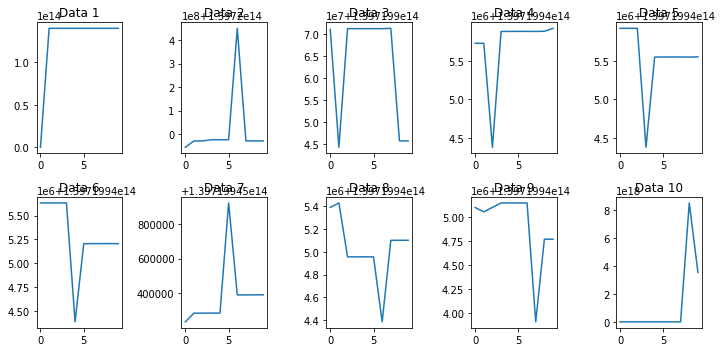

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Flatten the axes array so that we can iterate over it easily
axes = axes.ravel()

# Iterate over the data arrays and plot them in the corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(seq[i])
    ax.set_title("Data {}".format(i+1))

# Make the plots look nice
plt.tight_layout()
plt.show()


In [ ]:
#instead of using the random.choices function, we first repeat the locations array 
#by int(ntrial*np.sum(seq_complexity_i)) times and then use the random.sample function 
#to select ntrial unique random integers from the repeated locations array.

def create_sequences():
    random.seed(12)
    sequences_list = ['easy', 'easy', 'moderate_1', 'moderate_1', 'moderate_1', 'moderate_2', 'moderate_2', 'moderate_2', 'difficult', 'difficult']
    random.shuffle(sequences_list)
    for i in range(nseq):
        np.random.shuffle(locations)
        seq[i] = random.choices(locations, k=ntrial,weights=seq_complexity.get(sequences_list[i]))
    return seq

In [ ]:
def likelihood(array):
  #the prior distribution is uniform
  #let's create a dictionary
  occurrence = {1: 0, 2: 0, 3: 0, 4: 0} #
  #iterate over the arrays
  for loc in array:
    occurrence[loc] += 1
    
    #divide the likelihood of each locations by the total number of locations in the array
    #and the uniform prior probability of the number
  uniform_prior = 1/len(occurrence)
  for loc in occurrence:
    occurrence[loc] = (occurrence[loc] + uniform_prior)/(ntrial + len(occurrence))
  return occurrence 